## NEVER FORGET
  1. test all functions you made
  1. sign of anything wrong, dont ignore it,  
  1. start at least notes/graphs for thesis report 



## Todos:
  1. change shading to ci or se
  1. maybe change rnd training to train on sample that network trains from,   --> rerun everything
  1. try out 50, 70 100 tp chance
  1. change buffer to 20k buffer, 10k buffer
  1. check also with smaller/shorter epsilon, maybe also rnd exploration


## Agents atm:
  1. go towards state goal until value function stops increasing
  1. framestack on uvf network, 
  1. 2 networks 



## Questions to ask: 
  1. buffer size 500k fr? isnt that the whole experience - for my experiment use smaller buffer (20-50k ca)
  1. learning_starts? default (50k) or 0? - batch size
  1. for performance reasons would it make sense to make the states we want to start from a stack that gets updated whenever its either empty or regularily?   
    otherwise a lot of repeated computation and complicated structure 
     - stack makes sense 
  1. forgot, should tp move to unreachable states? or rather just load position of player? (currently just loads state got from buffer)
     - agent position (cause edge case where buffer only one level as impossible to leave)
  1. should RND be trained on whole buffer or just the ones we sampled or just the ones we sampled an kept? 
     - either train from sample from buffer or what you have seen in environment 


In [1]:
### Testing reset

from four_room.env import FourRoomsEnv
from four_room.wrappers import gym_wrapper
from four_room.utils import obs_to_state, obs_to_img
import gymnasium as gym
import dill

gym.register('MiniGrid-FourRooms-v1', FourRoomsEnv)

with open('./four_room/configs/fourrooms_train_config.pl', 'rb') as file:
    train_config = dill.load(file)
        #(player location x, player location y, player direction, goal location x, goal location y, 
         #   door position up, door position down, door position left, door position right)


def describe(state):
    state=obs_to_state(state)
    print("----Observation----")
    print(f"Player: {state[0]},{state[1]}, dir: {state[2]}")
    print(f"Goal: {state[3]},{state[4]}")
    print(f"Doors: up:{state[5]}, down:{state[6]}, left:{state[7]}, right:{state[8]}")



def make_env_fn(config, seed: int= 0, rank: int = 0):
    def _init():
        env = gym_wrapper(gym.make('MiniGrid-FourRooms-v1', 
                    agent_pos=config['agent positions'], 
                    goal_pos=config['goal positions'], 
                    doors_pos=config['topologies'], 
                    agent_dir=config['agent directions']))
        env.reset(seed=seed+rank)
        return env

    return _init

env = make_env_fn(train_config,seed=123958)()
target_env = make_env_fn(train_config,seed=412318)()

target, _ = target_env.reset()
obs,_ = env.reset(options={'load_state':target})
target2, _, _ , _ , _  = target_env.step(2)
obs2,  _ ,_ ,_ ,_  = env.step(2)

describe(target)
describe(obs)
describe(target2)
describe(obs2)


pygame 2.4.0 (SDL 2.26.4, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html
----Observation----
Player: 5,5, dir: 1
Goal: 2,1
Doors: up:0, down:1, left:1, right:1
----Observation----
Player: 5,5, dir: 1
Goal: 3,7
Doors: up:2, down:1, left:0, right:1
----Observation----
Player: 5,6, dir: 1
Goal: 2,1
Doors: up:0, down:1, left:1, right:1
----Observation----
Player: 5,6, dir: 1
Goal: 3,7
Doors: up:2, down:1, left:0, right:1


/home/felix/.local/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.width to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.width` for environment variables or `env.get_wrapper_attr('width')` that will search the reminding wrappers.
  logger.warn(
/home/felix/.local/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.height to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.height` for environment variables or `env.get_wrapper_attr('height')` that will search the reminding wrappers.
  logger.warn(


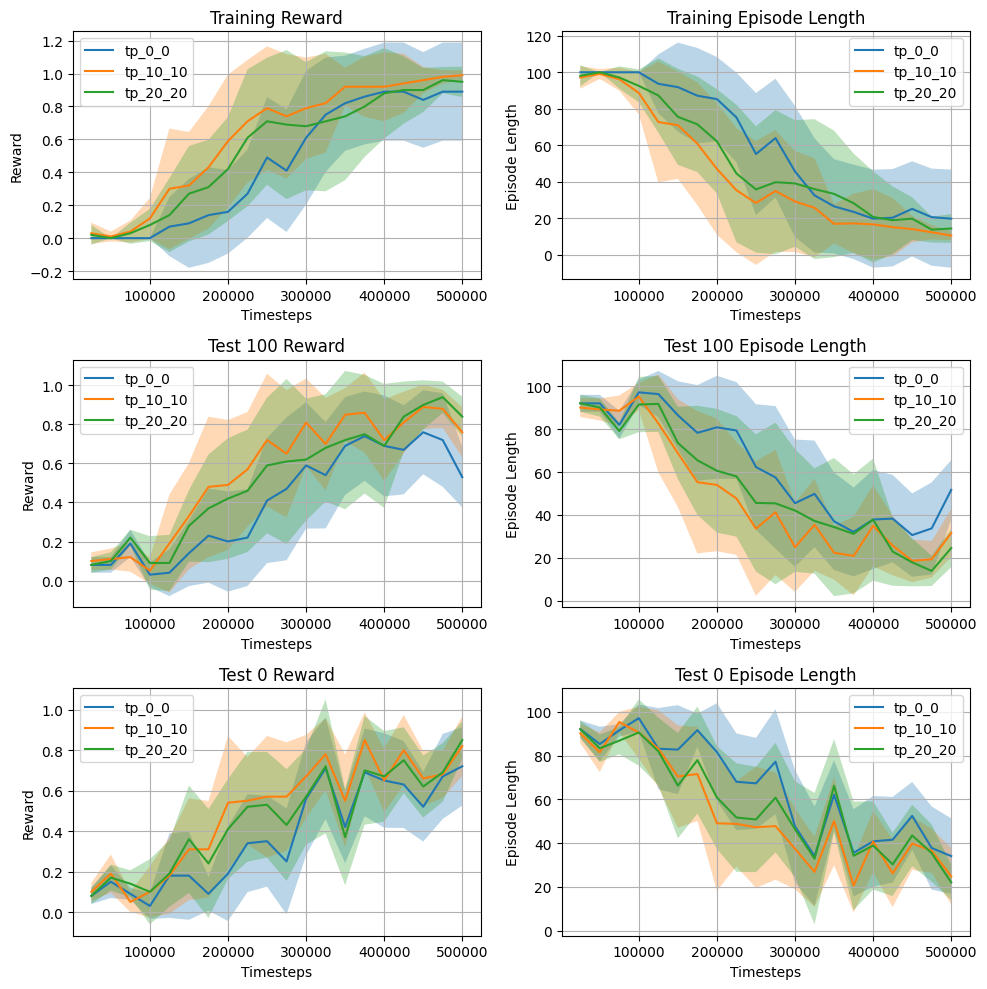

In [54]:
### Visualizing Results 50k buffer 5 runs###

import matplotlib.pyplot as plt
import numpy as np 
base_log='./logs/'

def load_data(env, name,runs=5):
    tmp=[np.load(f"{base_log}log_b50_{name}/{env}/{i}/evaluations.npz") for i in range(runs)]
    dt={}
    dt['results']=np.array([np.mean(i['results'],axis=1) for i in tmp])
    dt['ep_lengths']=np.array([np.mean(i['ep_lengths'],axis=1) for i in tmp])
    dt['timesteps']=tmp[0]['timesteps']
    return dt

def plot(ax, dt, title,name, ylabel, ydata):

    data=dt[ydata]
    mean=np.mean(data,axis=0)
    std=np.std(data,axis=0)

    ax.plot(dt['timesteps'],mean, label=name)
    ax.fill_between(dt['timesteps'],mean-std,mean+std,alpha=0.3)

    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Timesteps')
    ax.legend()
    ax.grid(True)

fig, ax = plt.subplots(3,2, figsize=(10,10))

for name in ['tp_0_0','tp_10_10','tp_20_20']:
    results={}
    for env in ['tr', '0', '100']:
        results[env]=load_data(env,name,10)

    plot(ax[0,0],results['tr'], 'Training Reward',name,'Reward','results')
    plot(ax[0,1],results['tr'], 'Training Episode Length',name, 'Episode Length','ep_lengths')

    plot(ax[1,0],results['100'], 'Test 100 Reward',name,'Reward','results')
    plot(ax[1,1],results['100'], 'Test 100 Episode Length',name, 'Episode Length','ep_lengths')

    plot(ax[2,0],results['0'], 'Test 0 Reward',name,'Reward','results')
    plot(ax[2,1],results['0'], 'Test 0 Episode Length',name, 'Episode Length','ep_lengths')

plt.tight_layout()

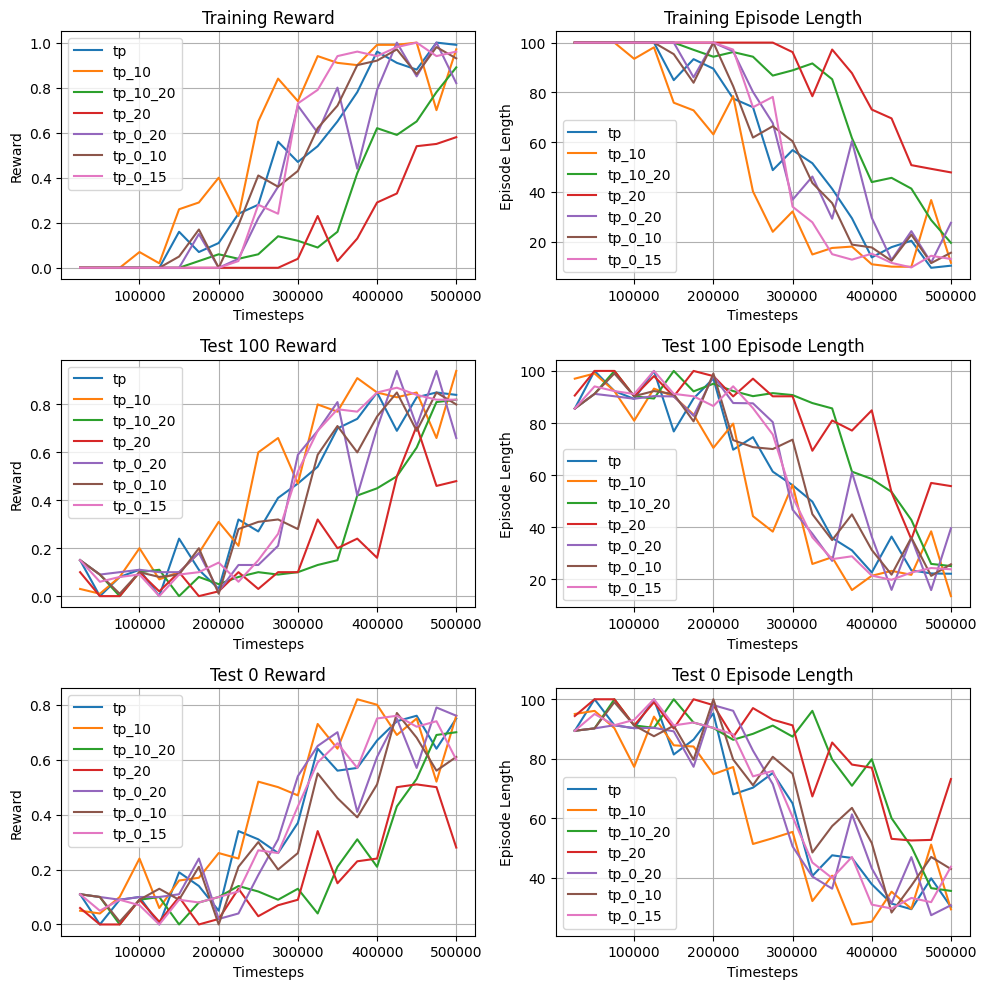

In [4]:
### Visualizing Results 500k buffer ###

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np 
results={}
base_log='./logs/'
def plot_reward(ax,dt, title,name):
    sns.lineplot(x=dt['timesteps'], label=name,y=dt['results'], ax=ax)
    ax.set_title(title)
    ax.set_ylabel('Reward')
    ax.set_xlabel('Timesteps')
    ax.grid(True)

def plot_episode_length(ax,dt, title,name):
    sns.lineplot(x=dt['timesteps'],label=name, y=dt['ep_lengths'], ax=ax)
    ax.set_title(title)
    ax.set_ylabel('Episode Length')
    ax.set_xlabel('Timesteps')
    ax.grid(True)

fig, ax = plt.subplots(3,2, figsize=(10,10))

for name in ['tp','tp_10','tp_10_20', 'tp_20' , 'tp_0_20','tp_0_10','tp_0_15']:
    for env in ['tr', '0', '100']:
        tmp=np.load(base_log+'log_'+name+'/'+env+'/evaluations.npz')
        results[env]={}
        results[env]['results']=np.mean(tmp['results'],axis=1)
        results[env]['ep_lengths']=np.mean(tmp['ep_lengths'],axis=1)
        results[env]['timesteps']=tmp['timesteps']

    plot_reward(ax[0,0],results['tr'], 'Training Reward',name)
    plot_episode_length(ax[0,1],results['tr'], 'Training Episode Length',name)

    plot_reward(ax[1,0],results['100'], 'Test 100 Reward',name)
    plot_episode_length(ax[1,1],results['100'], 'Test 100 Episode Length',name)

    plot_reward(ax[2,0],results['0'], 'Test 0 Reward',name)
    plot_episode_length(ax[2,1],results['0'], 'Test 0 Episode Length',name)

plt.tight_layout()

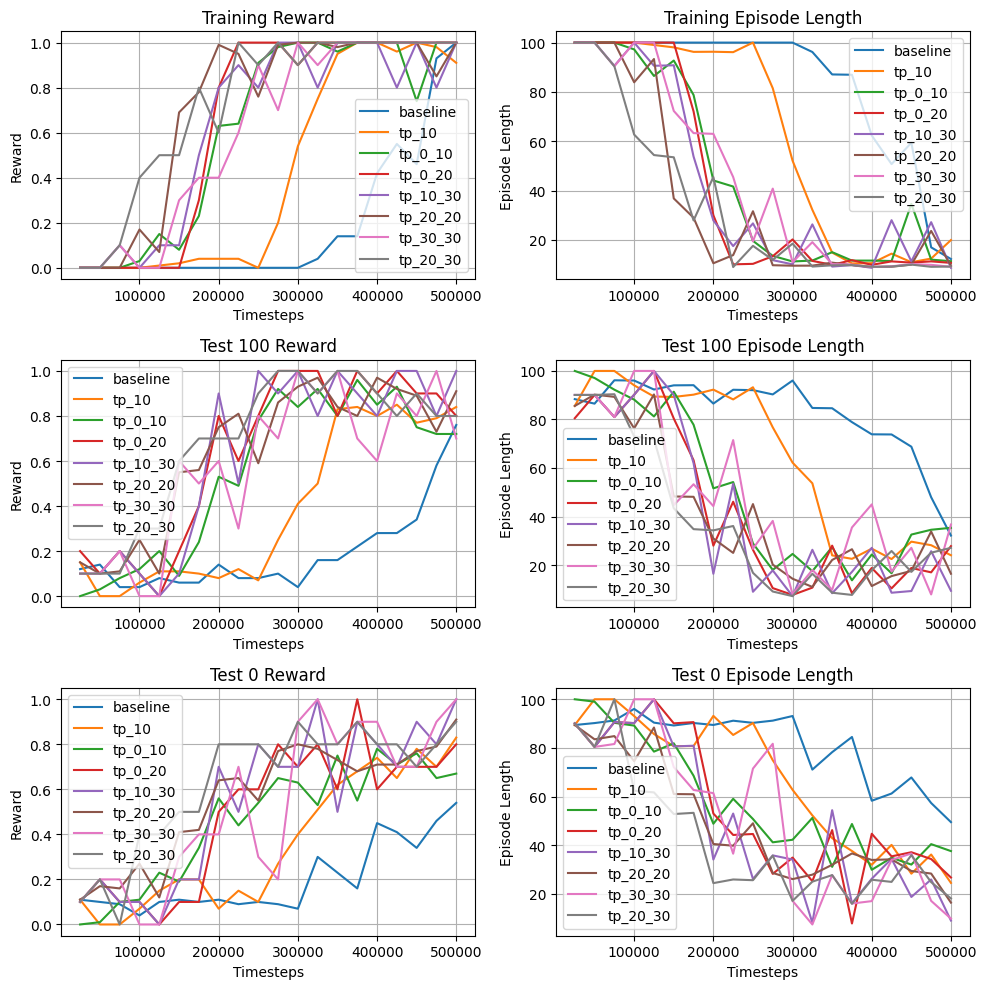

In [2]:
### Visualizing Results 50k buffer###

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np 
results={}
base_log='./logs/'
def plot_reward(ax,dt, title,name):
    sns.lineplot(x=dt['timesteps'], label=name,y=dt['results'], ax=ax)
    ax.set_title(title)
    ax.set_ylabel('Reward')
    ax.set_xlabel('Timesteps')
    ax.grid(True)

def plot_episode_length(ax,dt, title,name):
    sns.lineplot(x=dt['timesteps'],label=name, y=dt['ep_lengths'], ax=ax)
    ax.set_title(title)
    ax.set_ylabel('Episode Length')
    ax.set_xlabel('Timesteps')
    ax.grid(True)

fig, ax = plt.subplots(3,2, figsize=(10,10))

for name in ['baseline','tp_10','tp_0_10','tp_0_20','tp_10_30','tp_20_20','tp_30_30','tp_20_30']:
    for env in ['tr', '0', '100']:
        tmp=np.load(base_log+'log_b50_'+name+'/'+env+'/evaluations.npz')
        results[env]={}
        results[env]['results']=np.mean(tmp['results'],axis=1)
        results[env]['ep_lengths']=np.mean(tmp['ep_lengths'],axis=1)
        results[env]['timesteps']=tmp['timesteps']

    plot_reward(ax[0,0],results['tr'], 'Training Reward',name)
    plot_episode_length(ax[0,1],results['tr'], 'Training Episode Length',name)

    plot_reward(ax[1,0],results['100'], 'Test 100 Reward',name)
    plot_episode_length(ax[1,1],results['100'], 'Test 100 Episode Length',name)

    plot_reward(ax[2,0],results['0'], 'Test 0 Reward',name)
    plot_episode_length(ax[2,1],results['0'], 'Test 0 Episode Length',name)

plt.tight_layout()